# **Data Preprocessing**

In [1]:
# Importing necessary libraries
import os
from PIL import Image, UnidentifiedImageError
import numpy as np
from sklearn.preprocessing import LabelEncoder
import random
import pandas as pd
import random
from skimage import exposure

##### 🔹 `load_dataset` Function

This function loads images from the specified directory `a`, which is expected to contain `train` and `test` subdirectories.

Each of these subdirectories should include class-labeled folders (e.g., `Bears`, `Pandas`), each containing the respective image files.

- Iterates through both `train` and `test` folders.
- For each class (subfolder), it gathers image file paths and assigns labels based on the folder name.
- Only valid image formats are included: `.jpg`, `.jpeg`, `.png`, `.bmp`, and `.gif`.
- Returns a dictionary with:
  - `'train'`: list of `(image_path, label)` tuples.
  - `'test'`: list of `(image_path, label)` tuples.
- Displays how many images were loaded in total for each split.


In [2]:
def load_dataset(a):
    """
    Loads the dataset from a given directory, organizing images into 'train' and 'test' splits.

    Parameters:
        a (str): The base directory containing 'train' and 'test' subdirectories.

    Returns:
        dict: A dictionary with 'train' and 'test' splits containing image paths and labels.
    """
    dataset = {"train": [], "test": []}

    for split in ["train", "test"]:
        for class_name in os.listdir(os.path.join(a, split)):
            class_folder = os.path.join(a, split, class_name)
            if not os.path.isdir(class_folder):
                continue
            for file in os.listdir(class_folder):
                if file.lower().endswith(("jpg", "jpeg", "png", "bmp", "gif", "tiff")):
                    file_path = os.path.join(class_folder, file)
                    if os.path.getsize(file_path) > 0:
                        dataset[split].append((file_path, class_name))
                    else:
                        print(f"Skipped empty file: {file_path}")

    print(
        f"Loaded {len(dataset['train'])} train images and {len(dataset['test'])} test images."
    )
    return dataset

In [ ]:
file_path = "E:/PandasBears"
dataset = load_dataset(file_path)

Loaded 500 train images and 100 test images.


##### 🔹 `prepare_data` Function

This function processes all images in the dataset dictionary and prepares them for feature extraction by resizing and converting to grayscale.

- Converts each image to grayscale using `.convert('L')`.
- Resizes all images to a fixed shape (default: 150x150).
- Normalizes pixel values to range `[0, 1]`.
- Skips any corrupted or unreadable images and reports them.
- Returns a dictionary structured as:
  - `'train'`: contains `'images'` and `'labels'`
  - `'test'`: contains `'images'` and `'labels'`
  - Each `'images'` is a list of NumPy arrays, each representing a processed image.

In [4]:
def prepare_data(dataset, image_size=(150, 150)):
    """
    Prepares images by:
    - Converting to grayscale
    - Resizing
    - Enhancing contrast (optional)
    - Flattening the image to 1D vector

    Parameters:
        dataset (dict): Dictionary with 'train' and 'test' splits containing image paths and labels.
        image_size (tuple): Target size for images (default: 150x150).

    Returns:
        dict: Preprocessed images and labels for 'train' and 'test'.
    """
    prepared = {
        "train": {"images": [], "labels": [], "original_paths": []},
        "test": {"images": [], "labels": [], "original_paths": []},
    }

    def preprocess_image(img_path):
        try:
            img = Image.open(img_path).convert("L")  # Force grayscale
            img = img.resize(image_size)  # Resize image

            # Apply CLAHE (Contrast Limited Adaptive Histogram Equalization)
            img_array = np.array(img)
            img_array = exposure.equalize_adapthist(img_array, clip_limit=0.03)

            return img_array

        except Exception as e:
            print(f"Error processing {img_path}: {e}")
            return None

    for split in ["train", "test"]:
        for img_path, label in dataset[split]:
            img_array = preprocess_image(img_path)
            if img_array is not None:
                prepared[split]["images"].append(img_array)
                prepared[split]["labels"].append(label)
                prepared[split]["original_paths"].append(
                    img_path
                )  # store original path

    print(
        f"Prepared {len(prepared['train']['images'])} train and {len(prepared['test']['images'])} test images."
    )
    return prepared

In [5]:
prepared_data = prepare_data(dataset)

Prepared 500 train and 100 test images.


##### 🔹 `encode_labels` Function 

This function encodes string labels into integer values using Scikit-learn's `LabelEncoder`.

- Applies to both `'train'` and `'test'` splits of the dataset.
- Converts string labels (e.g., `'Bears'`, `'Pandas'`) into integer labels (e.g., `0`, `1`).
- Replaces the original string labels in the dataset with the encoded integers.
- Helps prepare labels for model training and evaluation that require numerical inputs.
- Prints the number of encoded labels for both splits.


In [6]:
def encode_labels(prepared_data):
    """
    Encodes string labels into integers using LabelEncoder (fitted only on train data).

    Parameters:
        prepared_data (dict): Data with 'train'/'test' splits.

    Returns:
        dict: Data with integer-encoded labels.
    """
    label_encoder = LabelEncoder()
    label_encoder.fit(prepared_data["train"]["labels"])

    for split in ["train", "test", "validation"]:
        if split in prepared_data:
            prepared_data[split]["labels"] = label_encoder.transform(
                prepared_data[split]["labels"]
            )

    print(f"Encoded labels. Classes: {label_encoder.classes_}")
    return prepared_data

In [7]:
# Call the function to encode labels
prepared_data = encode_labels(prepared_data)

Encoded labels. Classes: ['Bears' 'Pandas']


##### 🔹 `shuffle_data` Function

This function randomly shuffles training data to reduce order bias during model training.

- Keeps the association between each image and its corresponding label.
- Uses a fixed seed for reproducibility.
- Only affects the `train` split (not `test`).
- Displays the number of training samples shuffled.
- Returns the updated dictionary with shuffled training dat


In [8]:
def shuffle_data(prepared_data, seed=None):
    """
    Shuffles training data to avoid order bias.

    Parameters:
        prepared_data (dict): Dataset with 'train' split.
        seed (int): Optional seed for reproducibility.

    Returns:
        dict: Shuffled training data.
    """
    if seed is not None:
        random.seed(seed)

    # Change 'features' to 'images' as that is the correct key
    combined = list(
        zip(
            prepared_data["train"]["images"],  # assuming 'images' is the correct key
            prepared_data["train"]["labels"],
        )
    )
    random.shuffle(combined)
    prepared_data["train"]["images"], prepared_data["train"]["labels"] = zip(*combined)

    print(f"Shuffled {len(combined)} training samples.")
    return prepared_data

In [9]:
# Call the function to shuffle the data
prepared_data = shuffle_data(prepared_data)

Shuffled 500 training samples.


##### 🔹 `convert_to_dataframe` Function

This step converts the preprocessed image data and one-hot encoded labels into pandas DataFrames for easier analysis or model input preparation.

- `train_df` and `test_df` are created with:
  - `'image'`: column of image arrays.
  - `'label'`: column of one-hot encoded label vectors (as lists).
- Useful for viewing and manipulating data before feeding it into models.
- Displays the first few rows of each DataFrame using `.head()`.

In [10]:
def convert_to_dataframe(prepared_data):
    """
    Converts the prepared data into Pandas DataFrames for easier analysis.

    Parameters:
        prepared_data (dict): Data containing images and labels for 'train', 'test', and 'validation' splits.

    Returns:
        train_df, test_df, validation_df (DataFrames): Pandas DataFrames for training, test, and validation sets.
    """
    train_df = pd.DataFrame(
        {
            "image": prepared_data["train"]["images"],
            "label": prepared_data["train"]["labels"],  # encoded labels
        }
    )

    test_df = pd.DataFrame(
        {
            "image": prepared_data["test"]["images"],
            "label": prepared_data["test"]["labels"],  # encoded labels
        }
    )

    print("Train DataFrame:")
    print(train_df.head())

    print("\nTest DataFrame:")
    print(test_df.head())

    return train_df, test_df

In [11]:
train_df, test_df = convert_to_dataframe(prepared_data)

Train DataFrame:
                                               image  label
0  [[0.8052090975788702, 0.638236732697481, 0.588...      0
1  [[0.3035014691478942, 0.2694662095984329, 0.17...      1
2  [[0.3289095468167085, 0.20830530242798606, 0.1...      0
3  [[0.45276673800061146, 0.40324059920513605, 0....      0
4  [[0.11841620626151013, 0.19294045426642112, 0....      1

Test DataFrame:
                                               image  label
0  [[0.7371606749816582, 0.38475177304964536, 0.3...      0
1  [[0.5854389721627409, 0.3596206791067605, 0.31...      0
2  [[0.326161369193154, 0.21491442542787287, 0.15...      0
3  [[0.6754080322758115, 0.567210709701082, 0.511...      0
4  [[0.7710194590625382, 0.573002080528699, 0.461...      0


# **Feature Extraction**

- For this pandas vs. bears classification dataset, the feature extraction technique that will be used is **texture-based feature extraction method**.
- The reasons behind choosing this feature extraction method:
  1) Captures fur texture and patterns, which are key differences between pandas and bears.
  2) Not affected by shape or posture, unlike geometrical features.
  3) Provides rich texture descriptors (e.g., contrast, energy, homogeneity) for better classification.

In [12]:
# Importing necessary libraries
from skimage.feature import graycomatrix, graycoprops

In [13]:
# Calculate the gray-level co-occurrence matrix(GLCM) for the image. GLCM measures texture by looking at how often different gray-level pixel values occur next to each other in an image.
def extract_glcm_features(image, distances=[5], angles=[0], levels=256):

    # Ensure the image is 2D grayscale and writable
    image = np.ascontiguousarray(image.astype(np.uint8))

    # Compute GLCM matrix
    glcm = graycomatrix(
        image,  # input image, must be in gray scale
        distances=distances,  # the distance (in pixels) between the pixel of interest and its neighbor. 5 means we are comparing each pixel with the one 5 pixels to the right
        angles=angles,  # controls direction to look at neighboring pixels. 0 means horizontally to the right (other options are 45°, 90°, etc)
        levels=levels,  # number of gray levels expected in the image. For 8-bit grayscale, it's 256
        symmetric=True,  # makes the matrix symmetric, combining info from both directions. Think of it like saying:"A next to B" = "B next to A"
        normed=True,  # it normalizes the matrix values — turns counts into probabilities(percentages)
    )

    # Extract texture features from the co-occurrence matrix
    contrast = graycoprops(glcm, "contrast")[
        0, 0
    ]  # contrast measures the difference between the intensity of a pixel and its neighbors. High contrast = sharp transitions (edges, textures), Low contrast = smoother areas
    dissimilarity = graycoprops(glcm, "dissimilarity")[
        0, 0
    ]  # dissimilarity measures how different nearby pixel values are. High dissimilarity = lots of different pixels (rough or detailed textures, like forest, bricks), Low dissimilarity = similar pixels (smooth images, like sky or sea)
    homogeneity = graycoprops(glcm, "homogeneity")[
        0, 0
    ]  # homogeneity measures the likelihood of two pixels with different intensities being next to each other. High homogeneity = smooth textures (neighboring pixels have similar intensity), Low homogeneity = rough textures (neighboring pixels have different intensity)
    energy = graycoprops(glcm, "energy")[
        0, 0
    ]  # energy measures the uniformity of the texture. High energy = image has regular patterns, Low energy =  image has a lot of randomness or noise
    correlation = graycoprops(glcm, "correlation")[
        0, 0
    ]  # correlation measures the similarity between the intensity of a pixel and its neighbors. High correlation = pixels follow a pattern, Low correlation = pixels are random
    asm = graycoprops(glcm, "ASM")[
        0, 0
    ]  # ASM (Angular Second Moment) measures the uniformity of the texture and equals to the energy squared. High ASM = image has regular patterns, Low ASM =  image has a lot of randomness or noise

    return [contrast, dissimilarity, homogeneity, energy, correlation, asm]

In [14]:
# Apply GLCM to train dataset
train_features = []
for img in prepared_data["train"][
    "images"
]:  # loop through each image in the train dataset ato apply GLCM
    train_features.append(extract_glcm_features(img))

train_df = pd.DataFrame(  # create a DataFrame from the features extracted
    train_features,
    columns=[
        "contrast",
        "dissimilarity",
        "homogeneity",
        "energy",
        "correlation",
        "ASM",
    ],
)
train_df["label"] = prepared_data["train"]["labels"]  # add the labels to the dataframe

# Apply GLCM to test
test_features = []
for img in prepared_data["test"][
    "images"
]:  # loop through each image in the test dataset to apply GLCM
    test_features.append(extract_glcm_features(img))

test_df = pd.DataFrame(  # create a DataFrame from the features extracted
    test_features,
    columns=[
        "contrast",
        "dissimilarity",
        "homogeneity",
        "energy",
        "correlation",
        "ASM",
    ],
)
test_df["label"] = prepared_data["test"]["labels"]  # add the labels to the dataframe

In [15]:
train_df

,contrast,dissimilarity,homogeneity,energy,correlation,ASM,label
0,0.001057,0.001057,0.999471,0.998943,-0.000529,0.997887,0
1,0.010667,0.010667,0.994667,0.980802,0.611753,0.961973,1
2,0.001057,0.001057,0.999471,0.998943,-0.000529,0.997887,0
3,0.000828,0.000828,0.999586,0.999173,-0.000414,0.998346,0
4,0.010023,0.010023,0.994989,0.980395,0.653221,0.961174,1
...,...,...,...,...,...,...,...
495,0.000920,0.000920,0.999540,0.999081,-0.000460,0.998162,0
496,0.003310,0.003310,0.998345,0.996233,0.215733,0.992480,1
497,0.015126,0.015126,0.992437,0.976418,0.522983,0.953392,1
498,0.011632,0.011632,0.994184,0.981576,0.534944,0.963491,1


In [16]:
test_df

,contrast,dissimilarity,homogeneity,energy,correlation,ASM,label
0,0.002161,0.002161,0.998920,0.997840,-0.001082,0.995685,0
1,0.001701,0.001701,0.999149,0.998300,-0.000851,0.996602,0
2,0.000920,0.000920,0.999540,0.999081,-0.000460,0.998162,0
3,0.000736,0.000736,0.999632,0.999265,-0.000368,0.998530,0
4,0.001011,0.001011,0.999494,0.998989,-0.000506,0.997979,0
...,...,...,...,...,...,...,...
95,0.003954,0.003954,0.998023,0.995544,0.201722,0.991108,1
96,0.003080,0.003080,0.998460,0.996738,0.105124,0.993487,1
97,0.016046,0.016046,0.991977,0.977650,0.435241,0.955799,1
98,0.004690,0.004690,0.997655,0.994994,0.118339,0.990013,1


# **Model Training**

### `Approach 1 : Support Vector Machine(SVM)`

- For this dataset, the classification approach used is SVM classifier with GLCM-based texture feature extraction.

- Reasons behind choosing this model:
    1. GLCM captures key texture patterns like contrast and homogeneity, ideal for distinguishing between image types (as stated before).

    2. SVM performs well with high-dimensional texture features and small datasets.

    3. Hyperparameter tuning with GridSearchCV improves accuracy and model robustness.

    4. Offers clear interpretability, making it suitable for explainable ML tasks.

In [17]:
# Importing necessary libraries
from sklearn.svm import SVC  # support vector classifier
from sklearn.metrics import accuracy_score, classification_report  # evaluation metrics
from sklearn.model_selection import (
    train_test_split,
    GridSearchCV,
)  # for splitting and hyperparameter tuning
import seaborn as sns  # for plotting
import matplotlib.pyplot as plt  # or plotting

In [18]:
# Separate features and labels from the training and test datasets
X_train1 = train_df.drop(
    "label", axis=1
)  # remove the label column to get feature vectors
y_train1 = train_df["label"]  # labels for training set
X_test1 = test_df.drop("label", axis=1)  # feature vectors for testing
y_test1 = test_df["label"]  # corresponding labels for testing

# Further split the test set into validation and test sets (50% each)
X_val1, X_test1, y_val1, y_test1 = train_test_split(
    X_test1, y_test1, test_size=0.5, random_state=42, stratify=y_test1
)

# Print dataset sizes to verify
print(
    f"Train size: {len(X_train1)}, Val size: {len(X_val1)}, Test size: {len(X_test1)}"
)

Train size: 500, Val size: 50, Test size: 50


In [19]:
# Define a grid of hyperparameters for SVM to try
param_grid = {
    "C": [0.1, 1, 10],  # regularization parameter (lower means more regularization)
    "kernel": ["rbf", "linear", "poly"],  # type of kernel function to use
    "gamma": ["scale", "auto"],  # kernel coefficient for 'rbf' and 'poly'
}

# Create a GridSearchCV object with cross-validation
grid_search = GridSearchCV(SVC(), param_grid, cv=3, scoring="accuracy", verbose=2)

# Train the model using the training set and try all combinations of parameters
grid_search.fit(X_train1, y_train1)

Fitting 3 folds for each of 18 candidates, totalling 54 fits
[CV] END .....................C=0.1, gamma=scale, kernel=rbf; total time=   0.0s
[CV] END .....................C=0.1, gamma=scale, kernel=rbf; total time=   0.0s
[CV] END .....................C=0.1, gamma=scale, kernel=rbf; total time=   0.0s
[CV] END ..................C=0.1, gamma=scale, kernel=linear; total time=   0.0s
[CV] END ..................C=0.1, gamma=scale, kernel=linear; total time=   0.0s
[CV] END ..................C=0.1, gamma=scale, kernel=linear; total time=   0.0s
[CV] END ....................C=0.1, gamma=scale, kernel=poly; total time=   0.0s
[CV] END ....................C=0.1, gamma=scale, kernel=poly; total time=   0.0s
[CV] END ....................C=0.1, gamma=scale, kernel=poly; total time=   0.0s
[CV] END ......................C=0.1, gamma=auto, kernel=rbf; total time=   0.0s
[CV] END ......................C=0.1, gamma=auto, kernel=rbf; total time=   0.0s
[CV] END ......................C=0.1, gamma=auto

GridSearchCV(cv=3, estimator=SVC(),
             param_grid={'C': [0.1, 1, 10], 'gamma': ['scale', 'auto'],
                         'kernel': ['rbf', 'linear', 'poly']},
             scoring='accuracy', verbose=2)

#### *Visualization of Hyperparameter Results*

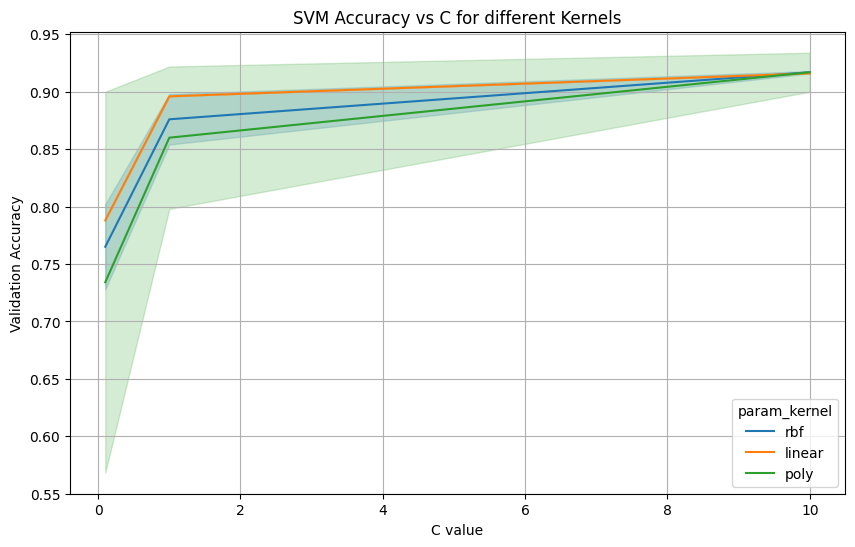

In [20]:
# Convert grid search results into a DataFrame for visualization
results_df = pd.DataFrame(grid_search.cv_results_)

# Plot accuracy vs C value for each kernel
plt.figure(figsize=(10, 6))
sns.lineplot(data=results_df, x="param_C", y="mean_test_score", hue="param_kernel")
plt.title("SVM Accuracy vs C for different Kernels")
plt.xlabel("C value")
plt.ylabel("Validation Accuracy")
plt.grid(True)
plt.show()

#### *Display Sorted Results*

In [21]:
# Rebuild DataFrame for clarity
results_df = pd.DataFrame(grid_search.cv_results_)

# Select columns of interest
relevant_cols = [
    "param_C",
    "param_kernel",
    "param_gamma",
    "mean_test_score",
    "std_test_score",
    "rank_test_score",
]

# Sort and show the top 10 parameter combinations by accuracy
sorted_results = results_df[relevant_cols].sort_values(
    by="mean_test_score", ascending=False
)
sorted_results.head(10)

,param_C,param_kernel,param_gamma,mean_test_score,std_test_score,rank_test_score
14,10.0,poly,scale,0.934011,0.012881,1
8,1.0,poly,scale,0.922011,0.008368,2
12,10.0,rbf,scale,0.918007,0.005538,3
15,10.0,rbf,auto,0.916011,0.004699,4
13,10.0,linear,scale,0.915999,0.004895,5
16,10.0,linear,auto,0.915999,0.004895,5
17,10.0,poly,auto,0.900019,0.007228,7
2,0.1,poly,scale,0.900019,0.007228,7
6,1.0,rbf,scale,0.898023,0.009558,9
7,1.0,linear,scale,0.896027,0.009930,10


In [22]:
# Extract the best estimator (SVM model with best hyperparameters)
best_svm = grid_search.best_estimator_
print("Optimal Hyperparameters:", grid_search.best_params_)

Optimal Hyperparameters: {'C': 10, 'gamma': 'scale', 'kernel': 'poly'}


### `Approach 2 : K-Nearest Neighbors(KNN)`


- For this dataset, the classification approach used is SVM classifier with GLCM-based texture feature extraction.

- The Reason Behind Choosing KNN:
  1) It makes decisions based on the proximity of data points, making it intuitive and easy to implement, especially when dealing with small datasets like ours (panda vs. bear images).

  2) we can find an optimal value that minimizes overfitting or underfitting, which is critical for improving the model’s generalization ability on unseen data.
  
  3) KNN serves as a good baseline model for comparison against more complex algorithms. It can provide a solid reference point to measure the performance of advanced models like CNNs.

In [23]:
# Importing necessary libraries
from sklearn.neighbors import (
    KNeighborsClassifier,
)  # importing KNN classifier from scikit-learn
from sklearn.metrics import accuracy_score  # for evaluation the model's performance

In [24]:
# Separate features and labels from the training and test datasets
X_train2 = train_df.drop(
    "label", axis=1
)  # remove the label column to get feature vectors
y_train2 = train_df["label"]  # labels for training set
X_test2 = test_df.drop("label", axis=1)  # feature vectors for testing
y_test2 = test_df["label"]  # corresponding labels for testing

# Further split the test set into validation and test sets (50% each)
X_val2, X_test2, y_val2, y_test2 = train_test_split(
    X_test2, y_test2, test_size=0.5, random_state=42, stratify=y_test2
)

# Print dataset sizes to verify
print(
    f"Train size: {len(X_train2)}, Val size: {len(X_val2)}, Test size: {len(X_test2)}"
)

Train size: 500, Val size: 50, Test size: 50


#### *Building the KNN model and hyperparameter tuning*


In [25]:
k_values = range(1, 21)  # 1 to 20 neighbors
val_scores = []  # to store the validation scores

# Loop through different values of k and calculate validation scores
for k in k_values:
    knn = KNeighborsClassifier(
        n_neighbors=k, metric="euclidean"
    )  # KNN classifier with Euclidean distance as a metric
    knn.fit(X_train2, y_train2.values.ravel())  # fit the model on the training data
    score = knn.score(X_val2, y_val2)  # calculate the score on the validation set
    val_scores.append(score)  # append the score to the list

# Finding the best k value
best_k = k_values[np.argmax(val_scores)]  # get the index of the maximum score
print(f"Best k value: {best_k}")

Best k value: 3


In [26]:
# Train the KNN model with the best k value
knn_model = KNeighborsClassifier(n_neighbors=best_k, metric="euclidean")
knn_model.fit(X_train2, y_train2)  # fit the model on the training data

KNeighborsClassifier(metric='euclidean', n_neighbors=3)

# **Model Evaluation**

### `1) SVM Model Evaluation`

In [27]:
# Importing necessary libraries
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from tabulate import tabulate

In [28]:
# Predicting on the validation and test sets
y_val_pred1 = best_svm.predict(X_val1)  # make predictions on the validation set
y_test_pred1 = best_svm.predict(X_test1)  # make predictions on the test set

##### 🔹 `Metrices` for  `Validation Set` and `Test Set` 


- `Accuracy` : Overall correctness (correct predictions / total predictions).
- `Precision` : Measures how many selected predictions were correct (avoid false positives).
- `Recall` : Measures how many actual positives were captured (avoid false negatives).
- `F1-Score` : Harmonic mean of precision and recall (balances both metrics).
- Prints all the metrices for the both sets



In [29]:
# Calculate evaluation metrics for the validation set
val_accuracy1 = accuracy_score(y_val1, y_val_pred1)

val_precision1 = precision_score(y_val1, y_val_pred1, average="weighted")

val_recall1 = recall_score(y_val1, y_val_pred1, average="weighted")

val_f1_1 = f1_score(y_val1, y_val_pred1, average="weighted")

In [30]:
# Print the evaluation metrics for the validation set
print("Validation Set Metrics:")

print(f"Accuracy: {val_accuracy1:.2f}")

print(f"Precision: {val_precision1:.2f}")

print(f"Recall: {val_recall1:.2f}")

print(f"F1-Score: {val_f1_1:.2f}\n")

Validation Set Metrics:
Accuracy: 0.94
Precision: 0.94
Recall: 0.94
F1-Score: 0.94



In [31]:
# Calculate evaluation metrics for the test set
test_accuracy1 = accuracy_score(y_test1, y_test_pred1)

test_precision1 = precision_score(y_test1, y_test_pred1, average="weighted")

test_recall1 = recall_score(y_test1, y_test_pred1, average="weighted")

test_f1_1 = f1_score(y_test1, y_test_pred1, average="weighted")

In [32]:
# Print the evaluation metrics for the test set
print("Test Set Metrics:")

print(f"Accuracy: {test_accuracy1:.2f}")

print(f"Precision: {test_precision1:.2f}")

print(f"Recall: {test_recall1:.2f}")

print(f"F1-Score: {test_f1_1:.2f}")

Test Set Metrics:
Accuracy: 0.92
Precision: 0.92
Recall: 0.92
F1-Score: 0.92


#### *Confusion Matrix*

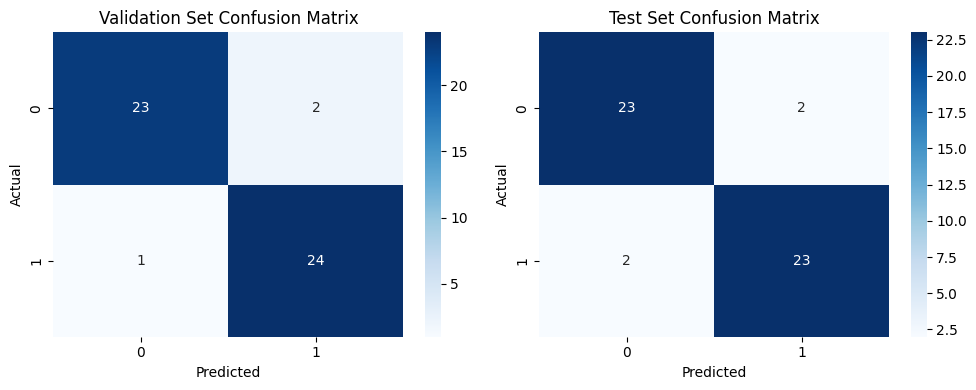

In [33]:
# Create confusion matrices
val_cm = confusion_matrix(y_val1, y_val_pred1)
test_cm = confusion_matrix(y_test1, y_test_pred1)

# Plot validation set confusion matrix
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
sns.heatmap(
    val_cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=best_svm.classes_,
    yticklabels=best_svm.classes_,
)
plt.title("Validation Set Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")

# Plot test set confusion matrix
plt.subplot(1, 2, 2)
sns.heatmap(
    test_cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=best_svm.classes_,
    yticklabels=best_svm.classes_,
)
plt.title("Test Set Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")

plt.tight_layout()
plt.show()

### `2) KNN Model Evaluation`

In [34]:
# Make predictions on validation and test sets
y_val_pred2 = knn_model.predict(X_val2)

y_test_pred2 = knn_model.predict(X_test2)

##### 🔹 `Metrices` for  `Validation Set` and `Test Set` 


- `Accuracy` : Overall correctness (correct predictions / total predictions).
- `Precision` : Measures how many selected predictions were correct (avoid false positives).
- `Recall` : Measures how many actual positives were captured (avoid false negatives).
- `F1-Score` : Harmonic mean of precision and recall (balances both metrics).
- Prints all the metrices for the both sets

In [35]:
# Calculate evaluation metrics for the validation set
val_accuracy2 = accuracy_score(y_val2, y_val_pred2)

val_precision2 = precision_score(y_val2, y_val_pred2, average="weighted")

val_recall2 = recall_score(y_val2, y_val_pred2, average="weighted")

val_f1_2 = f1_score(y_val2, y_val_pred2, average="weighted")

In [36]:
# Print the evaluation metrics for the validation set
print("Validation Set Metrics:")

print(f"Accuracy: {val_accuracy1:.2f}")

print(f"Precision: {val_precision1:.2f}")

print(f"Recall: {val_recall1:.2f}")

print(f"F1-Score: {val_f1_1:.2f}\n")

Validation Set Metrics:
Accuracy: 0.94
Precision: 0.94
Recall: 0.94
F1-Score: 0.94



In [37]:
# Print the evaluation metrics for the test set
test_accuracy2 = accuracy_score(y_test2, y_test_pred2)

test_precision2 = precision_score(y_test2, y_test_pred2, average="weighted")

test_recall2 = recall_score(y_test2, y_test_pred2, average="weighted")

test_f1_2 = f1_score(y_test2, y_test_pred2, average="weighted")

In [38]:
# Print the evaluation metrics for the test set
print("Test Set Metrics:")

print(f"Accuracy: {test_accuracy1:.2f}")

print(f"Precision: {test_precision1:.2f}")

print(f"Recall: {test_recall1:.2f}")

print(f"F1-Score: {test_f1_1:.2f}")

Test Set Metrics:
Accuracy: 0.92
Precision: 0.92
Recall: 0.92
F1-Score: 0.92


#### *Confusion Matrix*

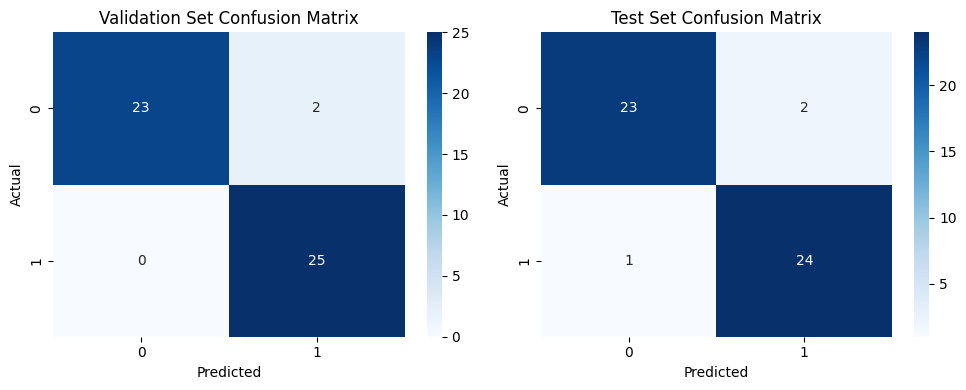

In [39]:
# Create confusion matrices
val_cm2 = confusion_matrix(y_val2, y_val_pred2)
test_cm2 = confusion_matrix(y_test2, y_test_pred2)

# Plot validation set confusion matrix
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
sns.heatmap(
    val_cm2,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=best_svm.classes_,
    yticklabels=best_svm.classes_,
)
plt.title("Validation Set Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")

# Plot test set confusion matrix
plt.subplot(1, 2, 2)
sns.heatmap(
    test_cm2,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=best_svm.classes_,
    yticklabels=best_svm.classes_,
)
plt.title("Test Set Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")

plt.tight_layout()
plt.show()

#### *Comparison between both Approaches*

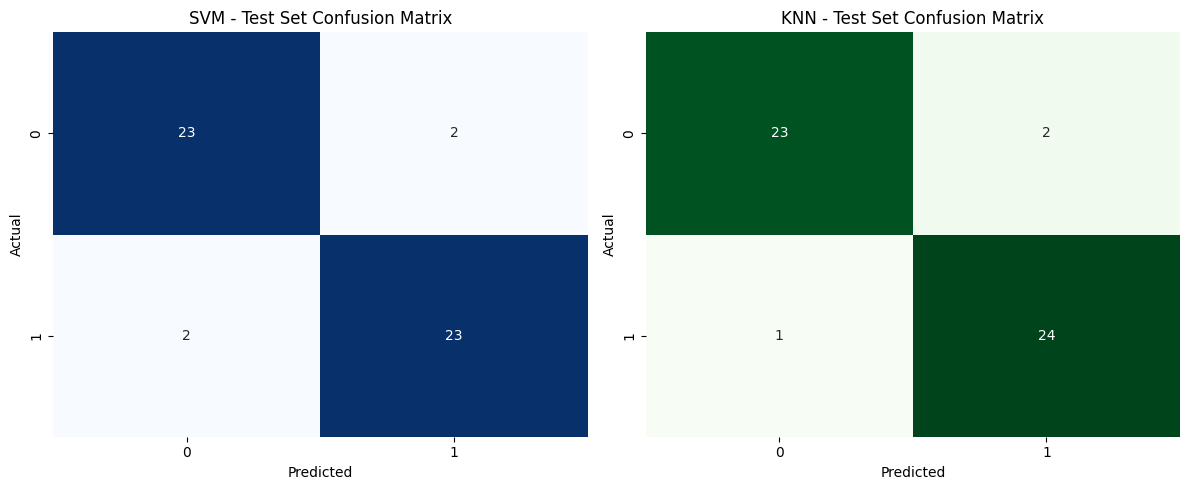

In [40]:
# Create confusion matrices
cm_svm = confusion_matrix(y_test2, y_test_pred1)
cm_knn = confusion_matrix(y_test2, y_test_pred2)

# Plot side by side
plt.figure(figsize=(12, 5))

# SVM Confusion Matrix
plt.subplot(1, 2, 1)
sns.heatmap(cm_svm, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title("SVM - Test Set Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")

# KNN Confusion Matrix
plt.subplot(1, 2, 2)
sns.heatmap(cm_knn, annot=True, fmt="d", cmap="Greens", cbar=False)
plt.title("KNN - Test Set Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")

plt.tight_layout()
plt.show()

In [41]:
comparison_data = [
    ["", "SVM", "KNN"],
    ["Validation Accuracy", f"{val_accuracy1:.2f}", f"{val_accuracy2:.2f}"],
    ["Validation Precision", f"{val_precision1:.2f}", f"{val_precision2:.2f}"],
    ["Validation Recall", f"{val_recall1:.2f}", f"{val_recall2:.2f}"],
    ["Validation F1-Score", f"{val_f1_1:.2f}", f"{val_f1_2:.2f}"],
    ["", "", ""],
    ["Test Accuracy", f"{test_accuracy1:.2f}", f"{test_accuracy2:.2f}"],
    ["Test Precision", f"{test_precision1:.2f}", f"{test_precision2:.2f}"],
    ["Test Recall", f"{test_recall1:.2f}", f"{test_recall2:.2f}"],
    ["Test F1-Score", f"{test_f1_1:.2f}", f"{test_f1_2:.2f}"],
]

# Print the table
print("Model Performance Comparison")
print(tabulate(comparison_data, headers="firstrow", tablefmt="grid"))

Model Performance Comparison
+----------------------+-------+-------+
|                      | SVM   | KNN   |
+======================+=======+=======+
| Validation Accuracy  | 0.94  | 0.96  |
+----------------------+-------+-------+
| Validation Precision | 0.94  | 0.96  |
+----------------------+-------+-------+
| Validation Recall    | 0.94  | 0.96  |
+----------------------+-------+-------+
| Validation F1-Score  | 0.94  | 0.96  |
+----------------------+-------+-------+
|                      |       |       |
+----------------------+-------+-------+
| Test Accuracy        | 0.92  | 0.94  |
+----------------------+-------+-------+
| Test Precision       | 0.92  | 0.94  |
+----------------------+-------+-------+
| Test Recall          | 0.92  | 0.94  |
+----------------------+-------+-------+
| Test F1-Score        | 0.92  | 0.94  |
+----------------------+-------+-------+


# **Visualization**

In [42]:
# Importing necessary libraries
import matplotlib.pyplot as plt
import random
from PIL import Image
import seaborn as sns
import cv2
import numpy as np
from sklearn.metrics import confusion_matrix
from skimage.feature import graycomatrix

#### *Image Visualization*

Loaded 500 train images and 100 test images.
Prepared 500 train and 100 test images.


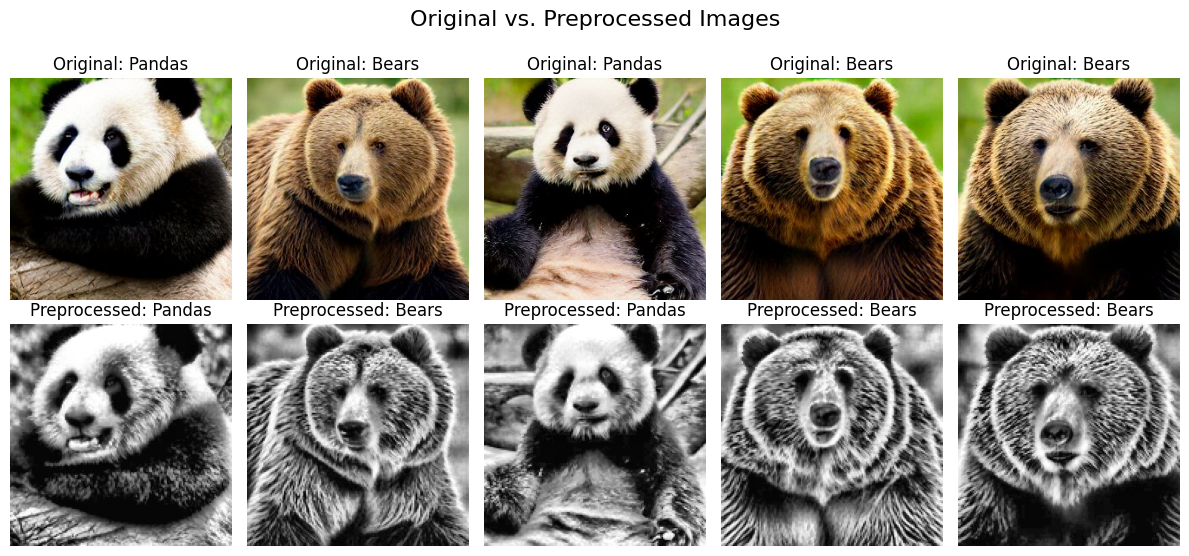

In [43]:
def visualize_images(prepared_data, num_images=5):
    """
    Visualizes original and preprocessed images with direct access to original paths.

    Args:
        prepared_data (dict): Preprocessed data containing images, labels, and original paths.
        num_images (int): Number of image pairs to visualize.
    """

    fig, axes = plt.subplots(2, num_images, figsize=(12, 6))
    fig.suptitle("Original vs. Preprocessed Images", fontsize=16)

    num_prepared_train = len(prepared_data["train"]["images"])
    if num_prepared_train == 0:
        print("No prepared training images to visualize.")
        plt.close()
        return

    random_indices = random.sample(
        range(num_prepared_train), min(num_images, num_prepared_train)
    )

    for i, idx in enumerate(random_indices):
        preprocessed_image = prepared_data["train"]["images"][idx]
        label = prepared_data["train"]["labels"][idx]
        original_path = prepared_data["train"]["original_paths"][idx]

        try:
            original_img = Image.open(original_path)
            axes[0, i].imshow(original_img)
            axes[0, i].set_title(f"Original: {label}")
            axes[0, i].axis("off")
        except FileNotFoundError:
            axes[0, i].set_title(f"Original (Not Found): {label}")
            axes[0, i].axis("off")

        axes[1, i].imshow(preprocessed_image, cmap="gray")
        axes[1, i].set_title(f"Preprocessed: {label}")
        axes[1, i].axis("off")

    plt.tight_layout(rect=[0, 0.03, 1, 0.98])
    plt.show()


# After loading data:
dataset = load_dataset(file_path)
prepared_data = prepare_data(dataset)

# After modifying prepare_data, call visualize_images like this:
visualize_images(prepared_data)

#### *Feature Correlation Matrix*

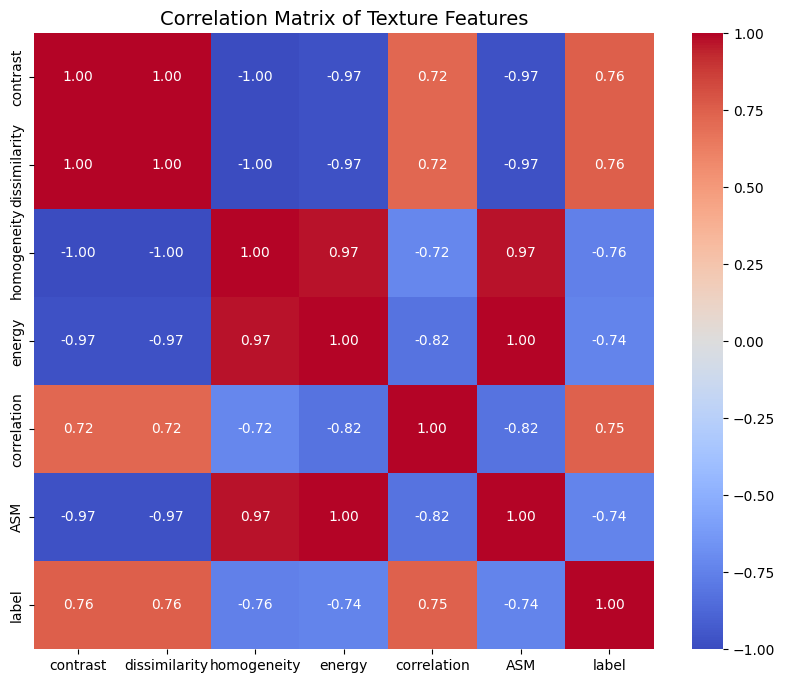

In [44]:
def visualize_feature_correlation(train_df):
    """
    Visualizes the correlation between the texture features extracted from the images.

    Parameters:
        train_df (pd.DataFrame): DataFrame containing the extracted features
                                 ('contrast', 'dissimilarity', 'homogeneity',
                                  'energy', 'correlation', 'ASM') and the 'label' column.
    """

    # Calculate the correlation matrix
    corr_matrix = train_df.corr()

    # Create a heatmap to visualize the correlation matrix
    plt.figure(figsize=(10, 8))  # adjust figure size for better readability
    sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f")
    plt.title("Correlation Matrix of Texture Features", fontsize=14)
    plt.show()


#  Call the visualization function
visualize_feature_correlation(train_df)

#### *Gray-Level Co-occurrence Matrix (GLCM)*

Loaded 500 train images and 100 test images.


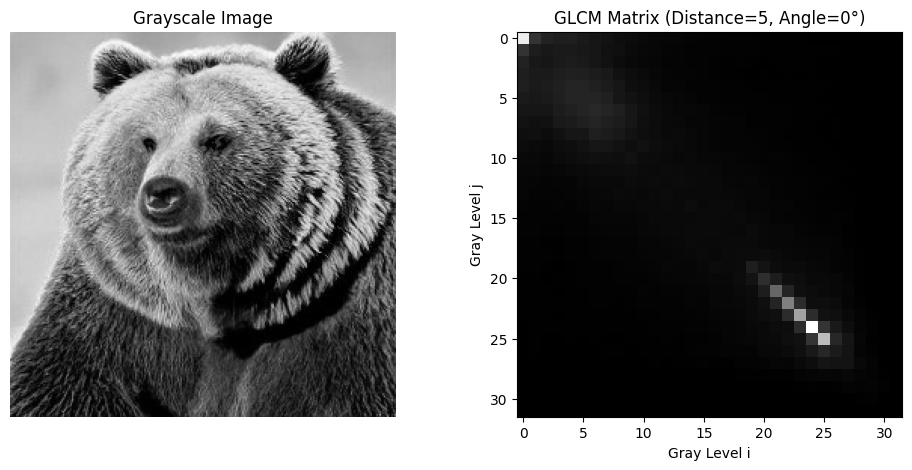

In [45]:
# Assume the function is already called
data = load_dataset(file_path)

# Get the first image from the training set
sample_path, label = data["train"][0]

# Load the image (in color)
img = cv2.imread(sample_path)

# Convert the image to grayscale
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# (Optional) Reduce gray levels to e.g., 32 to make the GLCM clearer
levels = 32
reduced_gray = (gray / (256 / levels)).astype(np.uint8)

# Compute the GLCM
glcm = graycomatrix(
    reduced_gray,
    distances=[5],
    angles=[0],  # 0-degree angle (horizontal)
    levels=levels,
    symmetric=True,
    normed=True,
)

# Extract the GLCM matrix itself
glcm_matrix = glcm[:, :, 0, 0]

# Display the grayscale image and the GLCM
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.imshow(gray, cmap="gray")
plt.title("Grayscale Image")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(glcm_matrix, cmap="gray", interpolation="nearest")
plt.title("GLCM Matrix (Distance=5, Angle=0°)")
plt.xlabel("Gray Level i")
plt.ylabel("Gray Level j")
plt.show()

#### *Confusion Matrix as a Bar Plot*

C:\Users\DELL\AppData\Local\Temp\ipykernel_28148\3360897689.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
C:\Users\DELL\AppData\Local\Temp\ipykernel_28148\3360897689.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


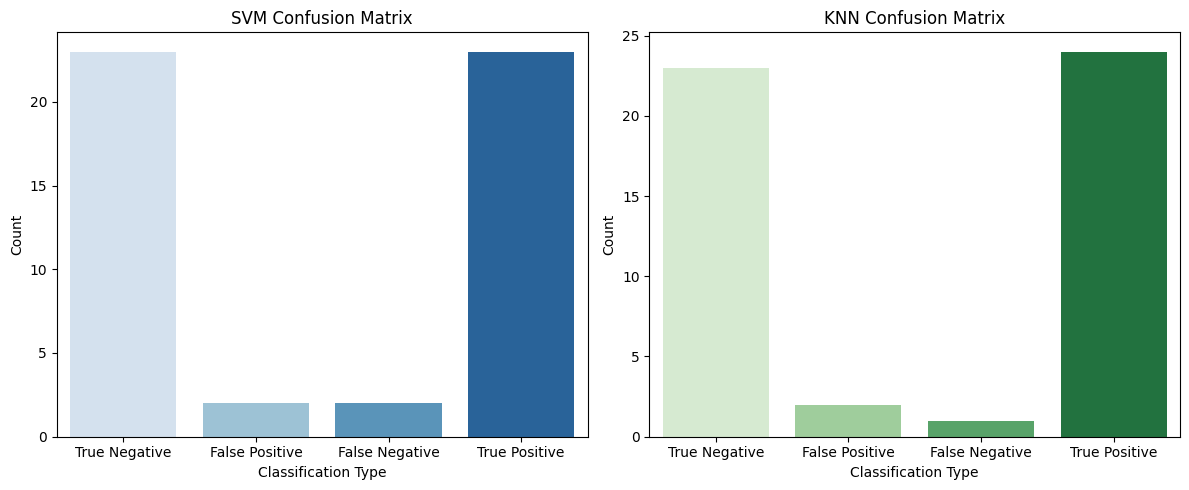

In [46]:
# Plot confusion matrix as a bar plot for each model
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Flatten the confusion matrices and create a label for each part
cm_svm_flat = cm_svm.flatten()
cm_knn_flat = cm_knn.flatten()

# Define the labels for each part of the confusion matrix
labels = ["True Negative", "False Positive", "False Negative", "True Positive"]

# Plot the SVM confusion matrix with a specific color palette
sns.barplot(
    x=labels, y=cm_svm_flat, ax=axes[0], palette="Blues"
)  # blue color palette for SVM
axes[0].set_title("SVM Confusion Matrix")
axes[0].set_ylabel("Count")
axes[0].set_xlabel("Classification Type")

# Plot the KNN confusion matrix with a different color palette
sns.barplot(
    x=labels, y=cm_knn_flat, ax=axes[1], palette="Greens"
)  # green color palette for KNN
axes[1].set_title("KNN Confusion Matrix")
axes[1].set_ylabel("Count")
axes[1].set_xlabel("Classification Type")

plt.tight_layout()
plt.show()